# Dynamic lot-size model

In [68]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Formulation

$$
\begin{align}
    \text{min}~~ & \sum_{t \in T}{(h_{t} I_{t} + s_{t} y_{t})} \\
    \text{s.t.}~~ & I_{t} = I_{t - 1} + x_{t} - d_{t} & \forall ~ t \in T; t \geq 2\\
    & I_{1} = I_{0} + x_{1} - d_{1}\\
    & x_{t} \leq M y_{t} & \forall ~ t \in T \\
    & x_{t}; I_{t} \geq 0 & \forall ~ t \in T \\
    & y_{t} \in \left \{ 0, 1 \right \} & \forall ~ t \in T\\
\end{align}
$$

## Import data

In [69]:
# Read input data
dataset = pd.read_csv("./input_wagner.csv", index_col=0)
dataset.head()

,setup_cost,inventory_cost,demand
t,,,
1,85,1.0,69
2,102,1.0,29
3,102,1.0,36
4,101,1.0,61
5,98,1.0,61


In [70]:
# Obtain the maximum cost for comparison
max_cost = dataset.setup_cost.sum()
print(f"Maximum cost: {max_cost:.1f}")

Maximum cost: 1234.0


In [71]:
dataset

,setup_cost,inventory_cost,demand
t,,,
1,85,1.0,69
2,102,1.0,29
3,102,1.0,36
4,101,1.0,61
5,98,1.0,61
6,114,1.0,26
7,105,1.0,34
8,86,1.0,67
9,119,1.0,45


## pyomo model

In [72]:
# Initialize ConcreteModel
model = pyo.ConcreteModel()

In [73]:
# Set: Planning horizon
model.T = pyo.Set(initialize=dataset.index.to_list())

In [74]:
# Parameters
model.demand = pyo.Param(model.T, initialize=dataset['demand'])
model.setup_cost = pyo.Param(model.T, initialize=dataset['setup_cost'])
model.inventory_cost = pyo.Param(model.T, initialize=dataset['inventory_cost'])

# Big M (can we do better?)
model.M = pyo.Param(initialize=sum(model.demand[:]))

In [75]:
# Decision variables
model.produced = pyo.Var(model.T, within=pyo.NonNegativeReals)
model.Decision = pyo.Var(model.T, within=pyo.Binary)
model.Inventory = pyo.Var(model.T, within=pyo.NonNegativeReals)

In [76]:
# Inventory balance *special in the first instant
def inventory_rule(model, t):
    if t == model.T.first():
        return model.Inventory[t] == model.produced[t] - model.demand[t]
    else:
        t_prev = model.T.prev(t)
        return model.Inventory[t] == model.Inventory[t_prev] + model.produced[t] - model.demand[t]


model.inventory_rule = pyo.Constraint(model.T, rule=inventory_rule)

In [77]:
# Indicator constraint activates y in case x is greater than zero
def active_prod(model, t):
    return model.produced[t] <= model.M * model.Decision[t]


model.active_prod = pyo.Constraint(model.T, rule=active_prod)

In [78]:
# Define the objective
def total_holding(model):
    return sum(model.inventory_cost[t] * model.Inventory[t] for t in model.T)


def total_setup(model):
    return sum(model.setup_cost[t] * model.Decision(t) for t in model.T)


def total_cost(model):
    return sum((model.inventory_cost[t] * model.Inventory[t])+(model.setup_cost[t] * model.Decision[t]) for t in model.T)


model.obj = pyo.Objective(rule=total_cost, sense=pyo.minimize)

## Solution

In [79]:
solver = pyo.SolverFactory("appsi_highs")

In [80]:
solver.solve(model, tee=True)

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 6e+02]
  Cost   [1e+00, 1e+02]
  Bound  [1e+00, 1e+00]
  RHS    [3e+01, 8e+01]
Presolving model
23 rows, 34 cols, 56 nonzeros  0s
22 rows, 34 cols, 55 nonzeros  0s

Solving MIP model with:
   22 rows
   34 cols (11 binary, 0 integer, 0 implied int., 23 continuous)
   55 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   85              inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   85              1234              93.11%        0      0      0         0     0.0s
         0       0         0   0.00%   176.9301587     1234              85.66%        0      0      0 

{'Problem': [{'Lower bound': 864.0, 'Upper bound': 864.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [81]:
opt_value = model.obj()
print(f"Best cost {opt_value}")
print(f"% savings {100 * (1 - opt_value / max_cost) :.2f}")

Best cost 864.0
% savings 29.98


In [82]:
dataset["production"] = [model.produced[t].value for t in dataset.index]
dataset["inventory"] = [model.Inventory[t].value for t in dataset.index]

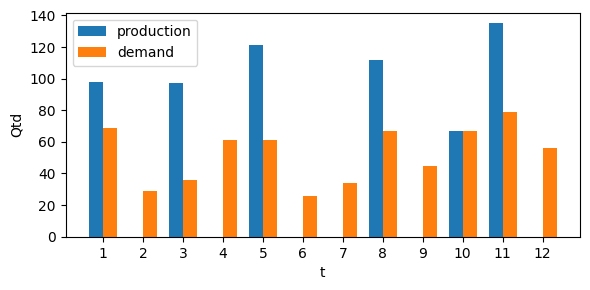

In [83]:
fig, ax = plt.subplots(figsize=[6, 3])
x = dataset.index
width = 0.35
ax.bar(x - width/2, dataset.production, width, label="production")
ax.bar(x + width/2, dataset.demand, width, label="demand")
ax.set_xticks(x)
ax.set_ylabel("Qtd")
ax.set_xlabel("t")
ax.legend()
fig.tight_layout()
plt.show()